# Asymmetry

This notebook tests the asymmetry calculations of targets with different properties. A skewed Gaussian model was used here. In the first test notebook, we tried flipping the lightcurve and then subtracting off one half with the other.

In [1]:
import os

os.chdir("../")
import lightkurve as lk
from matplotlib import pyplot as plt
import numpy as np
from astropy.table import Table
from scripts.analysis_tools_cython import *
import scipy.integrate as integrate
import numpy as np
from scipy.signal import savgol_filter

plt.rcParams["figure.figsize"] = (10, 6)

## Functions

In [131]:
def skewed_gaussian_curve_fit(x, y, y_err):
    # Initial parameters guess
    ## i = index of min time
    ## x = time
    ## y = flux

    i = np.argmin(y)
    y_err = normalise_flux(y_err)
    ### params initialisation for skewness, time, mean and sigma
    params_init = [0.01, x[i], 0.1, 0.0001]  # i find these good to initialise with

    # params_bounds = [[0,x[0],0,-np.inf], [np.inf,x[-1],np.inf,np.inf]]
    params, cov = curve_fit(
        updated_skewed_gauss, x, y, p0=params_init, maxfev=1000000,sigma=y_err
    )
    return params, cov


def updated_skewed_gauss(x, a, mean, sigma, m):
    """
    m: amplitude
    x: time
    a: skewness
    mean: time
    sigma: sigma/standard deviation

    """
    return -m * skewnorm.pdf(x, a, loc=mean, scale=sigma)


def lookup_tic(tic):
    return lookup[lookup.TIC_ID == tic]


def search_method(data):
    try:
        data = data["time", "corrected flux", "quality", "flux error"]
    except:
        data = data["TIME", "PDCSAP_FLUX", "QUALITY", "PDCSAP_FLUX_ERR"]

    flat_flux, trend_flux = smoothing(data, method="median")
    a = Table()
    a["time"] = data[data.colnames[0]]
    a["flux"] = flat_flux - np.ones(len(flat_flux))
    a["quality"] = data[data.colnames[2]]
    a["flux_error"] = data[data.colnames[3]]
    # table[table.colnames[1]] = flat_flux - np.ones(len(flat_flux)) # resets normalisation to zero instead of one.
    t, flux, quality, real, flux_error = clean_data(a)
    flux *= real
    timestep = calculate_timestep(data)
    factor = (1 / 48) / timestep

    T1 = test_statistic_array(flux, 60 * factor)

    m, n = np.unravel_index(
        T1.argmin(), T1.shape
    )  # T.argmin(): location of  T.shape: 2D array with x,y points in that dimension
    minT = T1[m, n]
    # Ts = nonzero(T1[m,n]).std()
    minT_time = t[n]
    minT_duration = m * timestep
    Tm_start = n - math.floor((m - 1) / 2)
    Tm_end = Tm_start + m
    Tm_depth = flux[Tm_start:Tm_end].mean()
    Ts = nonzero(T1[m]).std()  # only the box width selected. Not RMS of all T-statistic

    asym, width1, width2, depth, info, skew, skew_err = calc_shape(
        m, n, t, flux, quality, flux_error, n_m_bg_start=3
    )
    print(t)
    return info[0], info[1], info[3]


def plot(data):
    time, flux, _ = search_method(data)
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    try:
        ax[0].plot(data["time"], data["corrected flux"])
    except:
        ax[0].plot(data["TIME"], data["PDCSAP_FLUX"])
    ax[1].plot(time, flux)
    ax[1].plot(time, fit, label="gaussian")
    ax[1].plot(time, fit2, color="black", label="skewed gaussian")
    ax[1].legend()
    plt.show()

In [132]:
lookup = pd.read_csv("/storage/astro2/phrdhx/tesslcs/sector1lookup.csv")

## Example 1

In [133]:
data, lc_info = import_lightcurve(
    "betapic/hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_lc.fits"
)

In [134]:
time, flux, error = search_method(data)

[1468.3041536  1468.32498695 1468.3458203  ... 1489.99151787 1490.01235089
 1490.0331839 ]


In [135]:
params, cov = single_gaussian_curve_fit(time, -flux)
params1, cov1 = skewed_gaussian_curve_fit(time, flux, error)
print(time)
print(flux)
print(error)

[1484.38741326 1484.40824647 1484.42907959 1484.44991276 1484.47074592
 1484.49157908 1484.51241225 1484.53324541 1484.55407857 1484.57491174
 1484.5957449  1484.61657806 1484.63741122 1484.65824438 1484.67907754
 1484.6999107  1484.72074386 1484.74157702 1484.76241018 1484.78324334
 1484.8040765  1484.82490965 1484.84574281 1484.86657597 1484.88740912
 1484.90824228 1484.92907544 1484.94990859 1484.97074175 1484.9915749
 1485.01240805 1485.03324121 1485.05407436 1485.07490751 1485.09574067
 1485.11657382 1485.13740697 1485.15824012 1485.17907327 1485.19990642
 1485.22073957 1485.24157272 1485.26240587 1485.28323902 1485.30407217
 1485.32490532 1485.34573846 1485.36657161 1485.38740476 1485.4082379
 1485.42907105 1485.44990419 1485.47073734 1485.49157048 1485.51240363
 1485.53323677 1485.55406991 1485.57490306 1485.5957362  1485.61656934
 1485.63740248 1485.65823562 1485.67906877 1485.69990191 1485.72073505
 1485.74156819 1485.76240132 1485.78323446 1485.8040676  1485.82490074
 1485.84

In [136]:
print(f"skewness is {round(params1[0],3)}+/-{round(np.diag(cov1)[0],3)}")

skewness is 1.569+/-0.247


In [137]:
fit = -gauss(time, *params)
fit2 = updated_skewed_gauss(time, *params1)

[1468.3041536  1468.32498695 1468.3458203  ... 1489.99151787 1490.01235089
 1490.0331839 ]


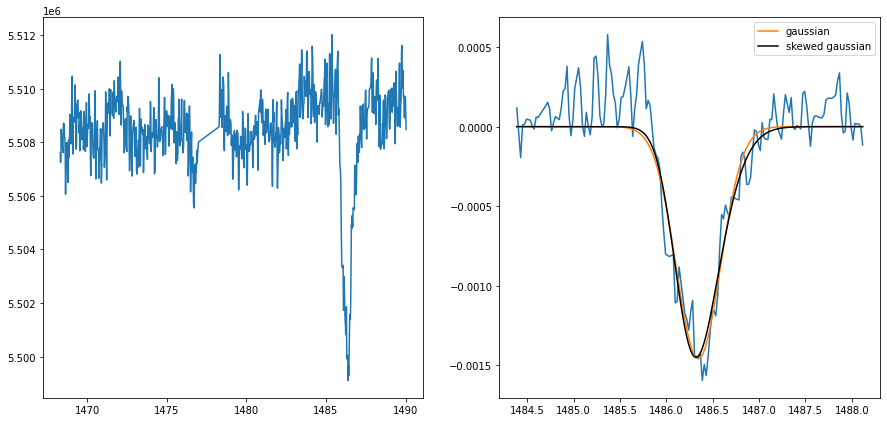

In [138]:
plot(data)

In [113]:
len(flux)

180

### 1a. Flip this lightcurve to see if the skew works in reverse as well

In [114]:
data = data.to_pandas()

In [115]:
data.head()

,TIME,PDCSAP_FLUX,QUALITY,PDCSAP_FLUX_ERR
0,1468.304154,5507612.0,0,64.862846
1,1468.324987,5507246.5,0,64.860832
2,1468.345820,5507478.5,0,64.863037
3,1468.366654,5508482.0,0,64.867645
4,1468.408320,5507866.5,0,64.860580


In [116]:
data.PDCSAP_FLUX = data.PDCSAP_FLUX.values[::-1]

In [117]:
data = Table.from_pandas(data)

In [118]:
time, flux, error = search_method(data)

[1468.3041536  1468.32498695 1468.3458203  ... 1489.99151787 1490.01235089
 1490.0331839 ]


In [119]:
params, cov = single_gaussian_curve_fit(time, -flux)
params1, cov1 = skewed_gaussian_curve_fit(time, flux, error)

In [120]:
print(f"skewness is {round(params1[0],3)}+/-{round(np.diag(cov1)[0],3)}")

skewness is -1.822+/-0.209


In [121]:
fit = -gauss(time, *params)
fit2 = updated_skewed_gauss(time, *params1)

[1468.3041536  1468.32498695 1468.3458203  ... 1489.99151787 1490.01235089
 1490.0331839 ]


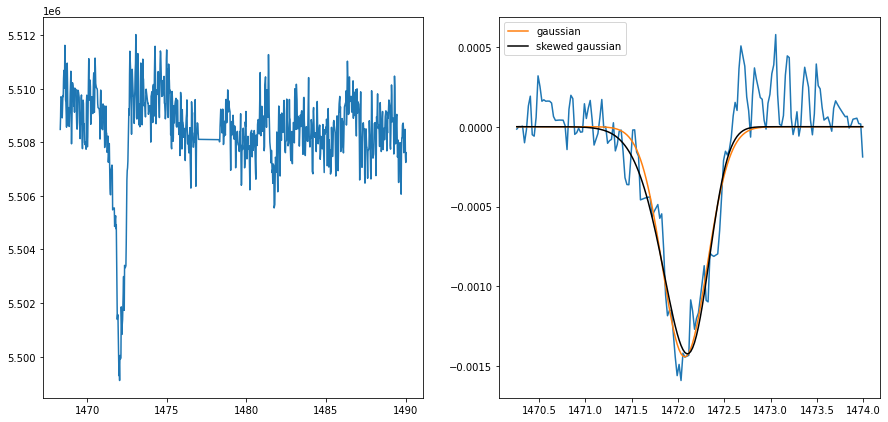

In [122]:
plot(data)

Fits the data quite well.

### Goodness of fit of model

In [20]:
chisquare = np.sum(((flux - fit2) ** 2) / fit2)

In [21]:
chisquare

-9938530453331424.0

---

## Example 2 (CTOI)

In [22]:
data, lc_info = import_XRPlightcurve(
    "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_50380257.pkl",
    sector=1,
)

In [23]:
time, flux = search_method(data)

In [24]:
params, cov = single_gaussian_curve_fit(time, -flux)
params1, cov1 = skewed_gaussian_curve_fit(time, flux)

In [25]:
print(f"skewness is {round(params1[0],3)}+/-{round(np.diag(cov1)[0],3)}")

skewness is 1.732+/-0.502


In [26]:
fit = -gauss(time, *params)
fit2 = updated_skewed_gauss(time, *params1)

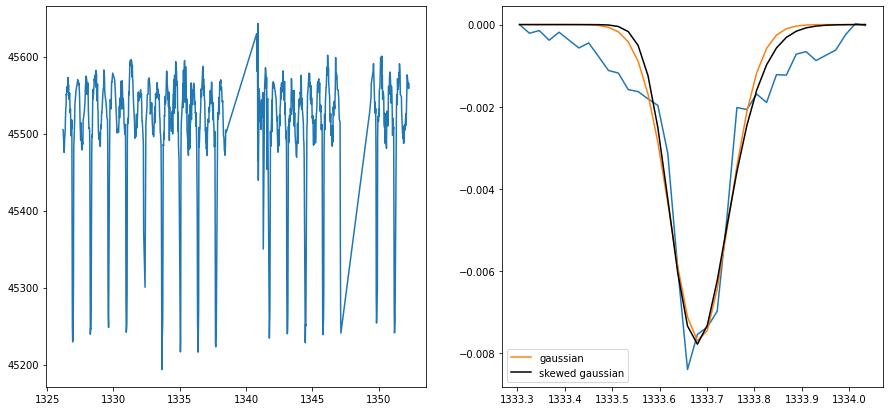

In [27]:
plot(data)

In [28]:
len(flux)

36

---
## Example 3 (CTOI)

In [29]:
lookup_tic(55659311)

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
12943,tesslcs_sector_1_104/2_min_cadence_targets/tes...,74.117326,-64.48753,55659311,1,4,1,9.7909


In [30]:
data, lc_info = import_XRPlightcurve(
    "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_55659311.pkl",
    sector=1,
)

In [31]:
time, flux = search_method(data)

In [32]:
params, cov = single_gaussian_curve_fit(time, -flux)
params1, cov1 = skewed_gaussian_curve_fit(time, flux)

In [33]:
print(f"skewness is {round(params1[0],3)}+/-{round(np.diag(cov1)[0],3)}")

skewness is 0.151+/-3.517


In [34]:
fit = -gauss(time, *params)
fit2 = updated_skewed_gauss(time, *params1)

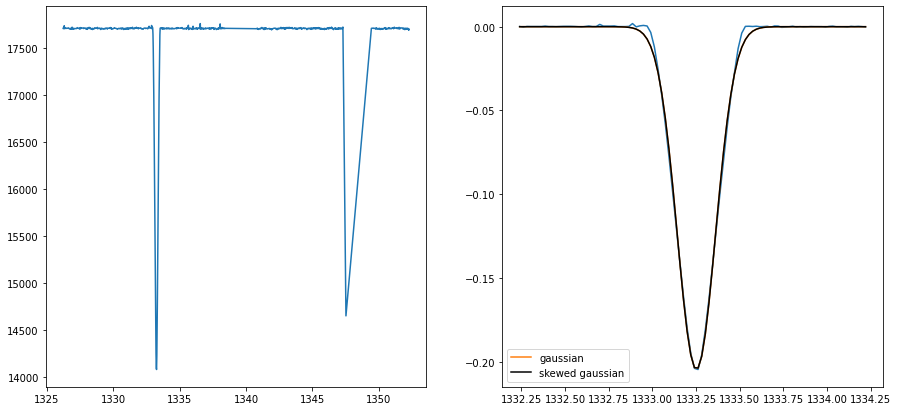

In [35]:
plot(data)

In [36]:
len(flux)

96

---
## Example 4 (EA2)

In [37]:
lookup_tic(60646247)

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
53662,tesslcs_sector_1_104/tesslcs_tmag_11_12/tesslc...,334.360488,-33.134487,60646247,1,1,2,11.851


In [38]:
data, lc_info = import_XRPlightcurve(
    "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/tesslcs_tmag_11_12/tesslc_60646247.pkl",
    sector=1,
)

In [39]:
time, flux = search_method(data)

In [40]:
params, cov = single_gaussian_curve_fit(time, -flux)
params1, cov1 = skewed_gaussian_curve_fit(time, flux)

In [41]:
print(f"skewness is {round(params1[0],3)}+/-{round(np.diag(cov1)[0],3)}")

skewness is 0.013+/-79896.402


In [42]:
fit = -gauss(time, *params)
fit2 = updated_skewed_gauss(time, *params1)

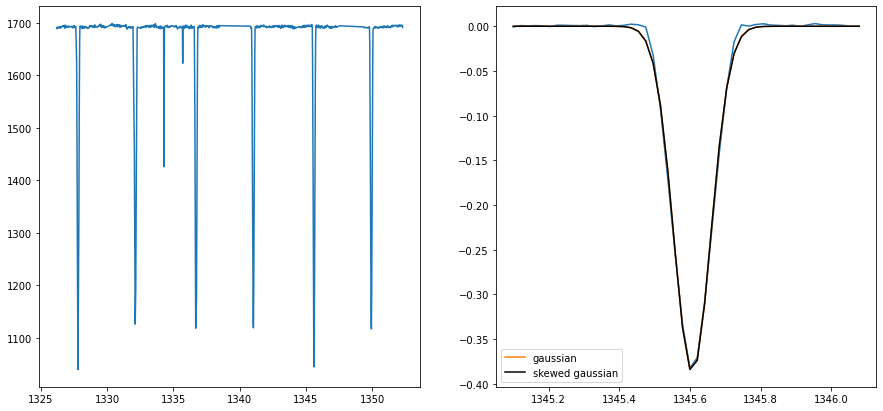

In [43]:
plot(data)

In [44]:
len(flux)

48

---
## Example 5 (WASP 100)

In [45]:
lookup_tic(38846515)

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
12850,tesslcs_sector_1_104/2_min_cadence_targets/tes...,68.959709,-64.027037,38846515,1,4,1,10.3157


In [46]:
data, lc_info = import_XRPlightcurve(
    "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_38846515.pkl",
    sector=1,
)

In [47]:
time, flux = search_method(data)

In [48]:
params, cov = single_gaussian_curve_fit(time, -flux)
params1, cov1 = skewed_gaussian_curve_fit(time, flux)

In [49]:
print(f"skewness is {round(params1[0],3)}+/-{round(np.diag(cov1)[0],3)}")

skewness is 15096.556+/-9256350628038826.0


In [50]:
params

array([8.40311019e-03, 1.32674718e+03, 4.25052679e-02])

In [51]:
fit = -gauss(time, *params)
fit2 = updated_skewed_gauss(time, *params1)

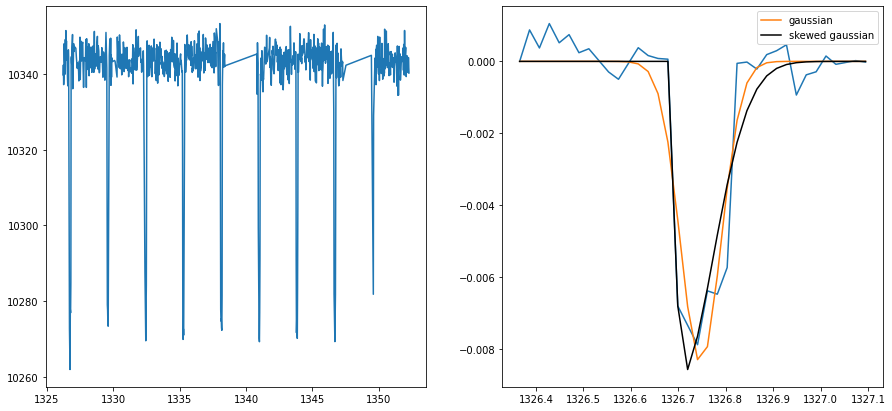

In [52]:
plot(data)

In [53]:
len(flux)

36

---
## Example 6

In [54]:
lookup_tic(61178236)

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
43296,tesslcs_sector_1_104/tesslcs_tmag_10_11/tesslc...,334.803809,-31.688934,61178236,1,1,2,10.8952


In [55]:
data, lc_info = import_XRPlightcurve(
    "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/tesslcs_tmag_10_11/tesslc_61178236.pkl",
    sector=1,
)

In [56]:
time, flux = search_method(data)

In [57]:
params, cov = single_gaussian_curve_fit(time, -flux)
params1, cov1 = skewed_gaussian_curve_fit(time, flux)

In [58]:
print(f"skewness is {round(params1[0],3)}+/-{round(np.diag(cov1)[0],3)}")

skewness is -0.206+/-17.204


In [59]:
params

array([1.27440359e-01, 1.34507985e+03, 3.19034840e-02])

In [60]:
fit = -gauss(time, *params)
fit2 = updated_skewed_gauss(time, *params1)

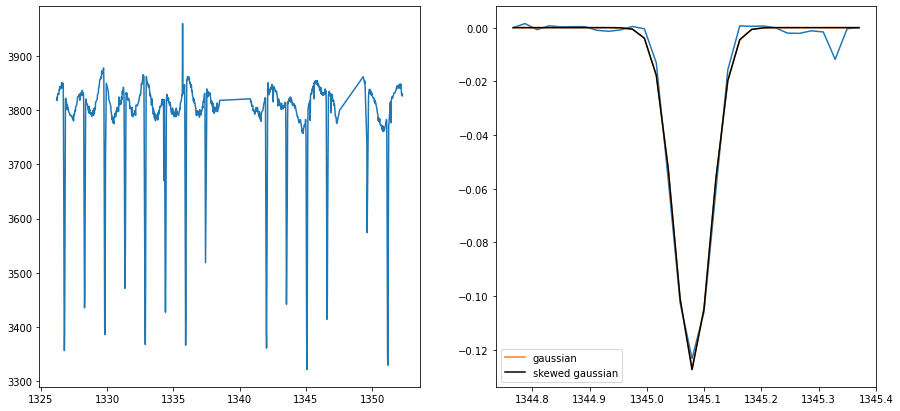

In [61]:
plot(data)

In [62]:
len(flux)

30

### Test interpolate

In [63]:
arange = np.linspace(time.min(), time.max(), 5000)
interp = np.interp(arange, time, flux)

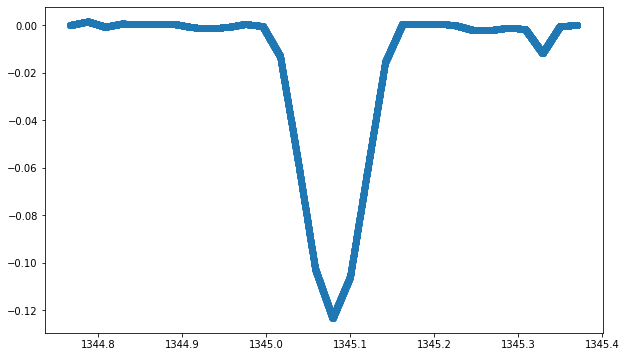

In [64]:
plt.scatter(arange, interp)